## AutoGluon Model

In this notebook, we train an AutoGluon model (without any feature engineering) which ties for 14th place out of 4,318 teams.  Arguably, this is the simplest high scoring model in the Kaggle competition.  After the model is trained, a residual plot is created and we address the explainability of the model.  Since the dataset for this Kaggle competition was synthetically generated from an existing dataset, we use our model on the original dataset to predict calorie expenditure.  Spoiler alert: it does very well.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from autogluon.tabular import TabularPredictor
import shap
from shap import KernelExplainer

In [2]:
# load train/test files
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
# log transform Calories and set Sex column as categorical
train_log = train
train_log['Calories'] = np.log1p(train['Calories'])
train_log['Sex'] = train_log['Sex'].astype('category')

# Encode Sex categorical feature to be compatable with SHAP
encoder = OrdinalEncoder()

train_log_enc = train_log.copy()
train_log_enc['Sex'] = encoder.fit_transform(train_log[['Sex']]).astype(int)

testsub = test.copy()
testsub['Sex'] = encoder.fit_transform(testsub[['Sex']]).astype(int)

train_log_enc.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189,82,26,101,41.0,5.017280
1,0,64,163,60,8,85,39.7,3.555348
2,0,51,161,64,7,84,39.8,3.401197
3,1,20,192,90,25,105,40.7,4.948760
4,0,38,166,61,25,102,40.6,4.990433


In [4]:
# Split data into training and testing sets
train_data, test_data = train_test_split(train_log_enc, test_size=0.2, random_state=724)

In [ ]:
# kaggle score 0.0 private, 0.0 public (autogluon_prediction_13.csv) (tied for ??th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=57600, # 16 hours
                                                                        num_bag_folds=5,  # 5 fold CV
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(testsub)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_13.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

No path specified. Models will be saved in: "AutogluonModels\ag-20250624_192943"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       22.46 GB / 31.61 GB (71.0%)
Disk Space Avail:   174.39 GB / 455.74 GB (38.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then hold

(_ray_fit pid=22248) [1000]	valid_set's rmse: 0.0641906
(_ray_fit pid=16180) [2000]	valid_set's rmse: 0.0599325 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=16180) [3000]	valid_set's rmse: 0.0595838 [repeated 5x across cluster]
(_ray_fit pid=16180) [4000]	valid_set's rmse: 0.0594207 [repeated 5x across cluster]
(_ray_fit pid=16180) [5000]	valid_set's rmse: 0.0593537 [repeated 5x across cluster]
(_ray_fit pid=16180) [6000]	valid_set's rmse: 0.0593362 [repeated 5x across cluster]
(_ray_fit pid=16180) [7000]	valid_set's rmse: 0.0593263 [repeated 4x across cluster]
(_ray_fit pid=16180) [8000]	valid_set's rmse: 0.0593195 [repeated 3x across cluster]
(_ray_fit pid=16180) [9000]	valid_set's rmse: 0.0593148


No path specified. Models will be saved in: "AutogluonModels\ag-20250623_052026"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       19.90 GB / 31.61 GB (63.0%)
Disk Space Avail:   186.96 GB / 455.74 GB (41.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=3, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then hold

(_ray_fit pid=18868) [1000]	valid_set's rmse: 0.0635363
(_ray_fit pid=16896) [2000]	valid_set's rmse: 0.0600771 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=16896) [3000]	valid_set's rmse: 0.0597203 [repeated 3x across cluster]
(_ray_fit pid=16896) [4000]	valid_set's rmse: 0.0596085 [repeated 3x across cluster]
(_ray_fit pid=16896) [5000]	valid_set's rmse: 0.0595409 [repeated 3x across cluster]
(_ray_fit pid=16896) [6000]	valid_set's rmse: 0.0595137 [repeated 3x across cluster]
(_ray_fit pid=16896) [7000]	valid_set's rmse: 0.0595102 [repeated 2x across cluster]
(_ray_fit pid=16896) [8000]	valid_set's rmse: 0.0594996 [repeated 2x across cluster]
(_ray_fit pid=16896) [9000]	valid_set's rmse: 0.0595166
(_ray_fit pid=16896) [10000]	valid_set's rmse: 0.0595372


(_dystack pid=14984) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	116.37s	 = Training   runtime
(_dystack pid=14984) 	90.49s	 = Validation runtime
(_dystack pid=14984) Fitting model: LightGBM_BAG_L1 ... Training model for up to 4629.78s of the 7029.00s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=0.99%)


(_ray_fit pid=16904) [1000]	valid_set's rmse: 0.0600558
(_ray_fit pid=24656) [1000]	valid_set's rmse: 0.062083


(_dystack pid=14984) 	-0.0605	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	17.4s	 = Training   runtime
(_dystack pid=14984) 	12.66s	 = Validation runtime
(_dystack pid=14984) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 4606.03s of the 7005.26s of remaining time.
(_dystack pid=14984) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=14984)   warnings.warn(
(_dystack pid=14984) 	-0.0635	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	57.4s	 = Training   runtime
(_dystack pid=14984) 	15.02s	 = Validation runtime
(_dystack pid=14984) Fitting model: CatBoost_BAG_L1 ... Training model for up to 4532.89s of the 6932.12s of remaining time.
(_dystack pi

(_ray_fit pid=16532) [1000]	valid_set's rmse: 0.0624228 [repeated 2x across cluster]
(_ray_fit pid=16532) [2000]	valid_set's rmse: 0.0618369 [repeated 3x across cluster]
(_ray_fit pid=16532) [3000]	valid_set's rmse: 0.0617764 [repeated 3x across cluster]
(_ray_fit pid=16532) [4000]	valid_set's rmse: 0.0617973 [repeated 3x across cluster]


(_dystack pid=14984) 	-0.0603	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	48.43s	 = Training   runtime
(_dystack pid=14984) 	88.71s	 = Validation runtime
(_dystack pid=14984) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 3079.38s of the 5478.60s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=1.67%)
(_ray_fit pid=22644) No improvement since epoch 4: early stopping
(_dystack pid=14984) 	-0.0658	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	1116.55s	 = Training   runtime
(_dystack pid=14984) 	8.72s	 = Validation runtime
(_dystack pid=14984) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 1957.06s of the 4356.28s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=3.11%

(_ray_fit pid=22448) [1000]	valid_set's rmse: 0.0856344 [repeated 3x across cluster]
(_ray_fit pid=22448) [2000]	valid_set's rmse: 0.0754191 [repeated 3x across cluster]
(_ray_fit pid=22448) [3000]	valid_set's rmse: 0.0705011 [repeated 3x across cluster]
(_ray_fit pid=22448) [4000]	valid_set's rmse: 0.0674079 [repeated 3x across cluster]
(_ray_fit pid=22448) [5000]	valid_set's rmse: 0.0655043 [repeated 3x across cluster]
(_ray_fit pid=22448) [6000]	valid_set's rmse: 0.0642652 [repeated 3x across cluster]
(_ray_fit pid=22448) [7000]	valid_set's rmse: 0.0635195 [repeated 3x across cluster]
(_ray_fit pid=22448) [8000]	valid_set's rmse: 0.0630307 [repeated 3x across cluster]
(_ray_fit pid=22448) [9000]	valid_set's rmse: 0.062682 [repeated 3x across cluster]
(_ray_fit pid=22448) [10000]	valid_set's rmse: 0.0624467 [repeated 3x across cluster]


(_dystack pid=14984) 	-0.0611	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	118.54s	 = Training   runtime
(_dystack pid=14984) 	233.61s	 = Validation runtime
(_dystack pid=14984) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 1636.10s of the 4035.33s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=0.95%)
(_dystack pid=14984) 	-0.0633	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	374.39s	 = Training   runtime
(_dystack pid=14984) 	1.84s	 = Validation runtime
(_dystack pid=14984) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 1258.47s of the 3657.70s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=1.42%)
(_dystack pid=14984) 	-0.0609	 = Validation score   (-root_mean_s

(_ray_fit pid=26244) [1000]	valid_set's rmse: 0.0636169 [repeated 3x across cluster]
(_ray_fit pid=5752) [2000]	valid_set's rmse: 0.0608416 [repeated 3x across cluster]
(_ray_fit pid=5752) [3000]	valid_set's rmse: 0.0602438 [repeated 3x across cluster]
(_ray_fit pid=5752) [4000]	valid_set's rmse: 0.0601066 [repeated 3x across cluster]
(_ray_fit pid=5752) [5000]	valid_set's rmse: 0.0600628 [repeated 3x across cluster]
(_ray_fit pid=5752) [6000]	valid_set's rmse: 0.0600649 [repeated 3x across cluster]
(_ray_fit pid=5752) [7000]	valid_set's rmse: 0.060071 [repeated 3x across cluster]


(_dystack pid=14984) 	-0.0605	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	138.02s	 = Training   runtime
(_dystack pid=14984) 	286.73s	 = Validation runtime
(_dystack pid=14984) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 304.78s of the 2704.00s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=1.68%)
(_ray_fit pid=15984) 	Ran out of time, stopping training early. (Stopping on epoch 5)
(_dystack pid=14984) 	-0.0686	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	227.74s	 = Training   runtime
(_dystack pid=14984) 	13.2s	 = Validation runtime
(_ray_fit pid=22240) 	Ran out of time, stopping training early. (Stopping on epoch 5) [repeated 2x across cluster]
(_dystack pid=14984) Fitting model: XGBoost_r89_BAG_L1 ... Training model for up to 69.86s of the 2469.09s of remaining time.
(_dystack pid=14984

(_ray_fit pid=16760) [1000]	valid_set's rmse: 0.0609895 [repeated 3x across cluster]
(_ray_fit pid=16760) [2000]	valid_set's rmse: 0.0609612 [repeated 3x across cluster]
(_ray_fit pid=18852) [3000]	valid_set's rmse: 0.0586862 [repeated 3x across cluster]
(_ray_fit pid=18852) [4000]	valid_set's rmse: 0.0587316


(_dystack pid=14984) 	-0.0602	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	70.13s	 = Training   runtime
(_dystack pid=14984) 	23.78s	 = Validation runtime
(_dystack pid=14984) Fitting model: LightGBM_BAG_L2 ... Training model for up to 2307.40s of the 2307.21s of remaining time.
(_dystack pid=14984) 	Fitting 3 child models (S1F1 - S1F3) | Fitting with ParallelLocalFoldFittingStrategy (3 workers, per: cpus=5, gpus=0, memory=2.86%)
(_dystack pid=14984) 	-0.0597	 = Validation score   (-root_mean_squared_error)
(_dystack pid=14984) 	8.44s	 = Training   runtime
(_dystack pid=14984) 	1.02s	 = Validation runtime
(_dystack pid=14984) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 2295.22s of the 2295.03s of remaining time.
(_dystack pid=14984) Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
(_dystack pid=14984) Unhandl


Train prediction: 0.053644951527516783
Test prediction: 0.05904780222921186


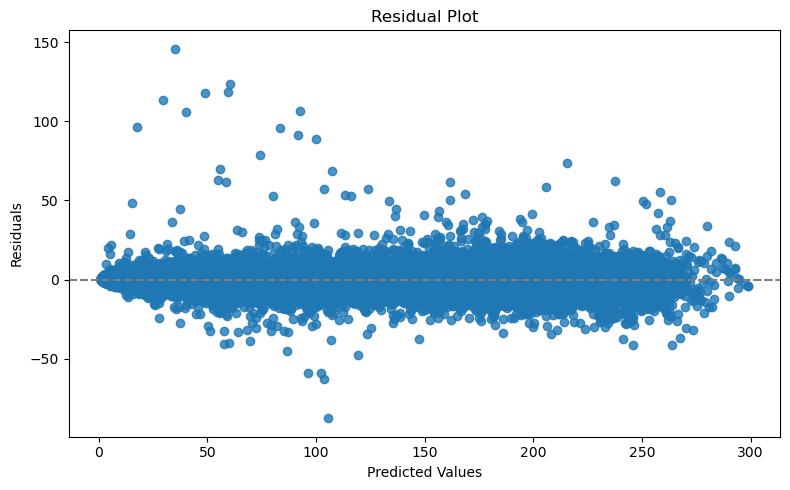

       id    Calories
0  750000   27.240858
1  750001  107.926712
2  750002   87.376411
3  750003  125.559860
4  750004   75.992645

count    250000.000000
mean         88.156982
std          62.243031
min           1.022787
25%          34.046647
50%          76.393105
75%         135.311615
max         299.033081
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.05850 private, 0.05709 public (autogluon_prediction_12.csv) (tied for 17th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=28800, # 8 hours
                                                                        num_bag_folds=3,  # 3 fold CV
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_12.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### Explainability

What is this AutoGluon model comprised of and what features does it value?

In [ ]:
# load model information
# predictor = TabularPredictor.load(r"c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250623_052026")
info = predictor.info()

In [23]:
print("AutoGluon trained a total of", len(predictor.leaderboard()), "different models.  " \
"The top performing model is", predictor.leaderboard().iloc[0]['model'], "which is a stacked ensemble of")
info['model_info']['WeightedEnsemble_L3']['features']

AutoGluon trained a total of 72 different models.  The top performing model is WeightedEnsemble_L3 which is a stacked ensemble of


['LightGBM_r130_BAG_L1',
 'LightGBMXT_BAG_L2',
 'XGBoost_r194_BAG_L1',
 'LightGBM_r188_BAG_L1',
 'NeuralNetFastAI_BAG_L1',
 'RandomForestMSE_BAG_L2',
 'ExtraTreesMSE_BAG_L2',
 'XGBoost_r33_BAG_L2',
 'CatBoost_r9_BAG_L2',
 'CatBoost_r167_BAG_L1',
 'CatBoost_BAG_L2',
 'ExtraTrees_r42_BAG_L2',
 'RandomForest_r39_BAG_L1',
 'NeuralNetFastAI_r156_BAG_L1']

In [26]:
print("The top 10 performing models are:")
predictor.leaderboard().head(10)

The top 10 performing models are:


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059063,root_mean_squared_error,1828.112023,17050.410438,0.011103,8.993313,3,True,72
1,WeightedEnsemble_L2,-0.059225,root_mean_squared_error,683.809024,1825.266356,0.008582,6.881490,2,True,51
2,ExtraTrees_r42_BAG_L2,-0.059353,root_mean_squared_error,1740.435272,13833.849732,23.493820,269.172056,2,True,69
3,ExtraTreesMSE_BAG_L2,-0.059418,root_mean_squared_error,1739.476779,13912.749963,22.535327,348.072287,2,True,56
4,CatBoost_r9_BAG_L2,-0.059498,root_mean_squared_error,1717.879872,13713.956021,0.938420,149.278345,2,True,65
5,LightGBM_r96_BAG_L2,-0.059539,root_mean_squared_error,1979.757186,13761.751684,262.815735,197.074008,2,True,66
6,LightGBM_r131_BAG_L2,-0.059543,root_mean_squared_error,1726.812291,13607.851954,9.870839,43.174278,2,True,63
7,LightGBM_BAG_L2,-0.059545,root_mean_squared_error,1718.275956,13580.058385,1.334504,15.380709,2,True,53
8,CatBoost_r13_BAG_L1,-0.059590,root_mean_squared_error,0.448781,326.083370,0.448781,326.083370,1,True,23
9,XGBoost_BAG_L2,-0.059612,root_mean_squared_error,1719.375020,13593.324783,2.433568,28.647108,2,True,58


#### Feature importance:

In [24]:
predictor.feature_importance(train_data)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	1109.61s	= Expected runtime (221.92s per shuffle set)
	715.26s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Duration,0.811842,0.010498,3.354137e-09,5,0.833457,0.790227
Heart_Rate,0.453137,0.013239,8.733808e-08,5,0.480396,0.425877
Age,0.113189,0.002289,2.004378e-08,5,0.117901,0.108476
Sex,0.060145,0.002040,1.585090e-07,5,0.064345,0.055945
Body_Temp,0.035273,0.001989,1.208267e-06,5,0.039369,0.031178
Weight,0.016707,0.000705,3.789828e-07,5,0.018158,0.015256
Height,0.003781,0.000398,1.446297e-05,5,0.004600,0.002962


In [56]:
predict_fn = lambda X: predictor.predict(X)

background = train_data.sample(100, random_state=724)
explainer = shap.Explainer(predict_fn, background)

to_explain = test_data.sample(50, random_state=724)

In [57]:
# 1a. Encode any object columns
def encode_df(df):
    df = df.copy()
    for c in df.select_dtypes(include="object"):
        df[c] = df[c].astype("category").cat.codes
    return df

bg = encode_df(background).astype(np.float64)
tx = encode_df(to_explain).astype(np.float64)

# 1b. (Re-)create your explainer, passing numpy arrays
explainer = shap.Explainer(predict_fn,
                           bg.values,
                           feature_names=bg.columns.tolist())

# 1c. Compute SHAP values on the float array
shap_values = explainer(tx.values)

ValueError: Cannot cast object dtype to float64

In [ ]:
bg = encode_df(background).astype(np.float64)
tx = encode_df(to_explain).astype(np.float64)

# KernelExplainer (slower, but very general)
kern = KernelExplainer(predict_fn, bg.values)
shap_values = kern.shap_values(tx.values, nsamples=100)

In [54]:
to_explain = test_data.sample(50, random_state=724)
shap_values = explainer(to_explain)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

#### Model performance on original dataset

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Calories Burnt Prediction](https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction) dataset.  How does our model perform on the original dataset?

In [33]:
# read original dataset
orig = pd.read_csv("calories_original_dataset.csv").drop(columns='User_ID')
orig.rename(columns={'Gender': 'Sex'}, inplace=True)
orig['Calories'] = np.log1p(orig['Calories'])

orig.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,5.446737
1,female,20,166.0,60.0,14.0,94.0,40.3,4.204693
2,male,69,179.0,79.0,5.0,88.0,38.7,3.295837
3,female,34,179.0,71.0,13.0,100.0,40.5,4.276666
4,female,27,154.0,58.0,10.0,81.0,39.8,3.583519


Original dataset prediction RMSLE: 0.027442446515476407


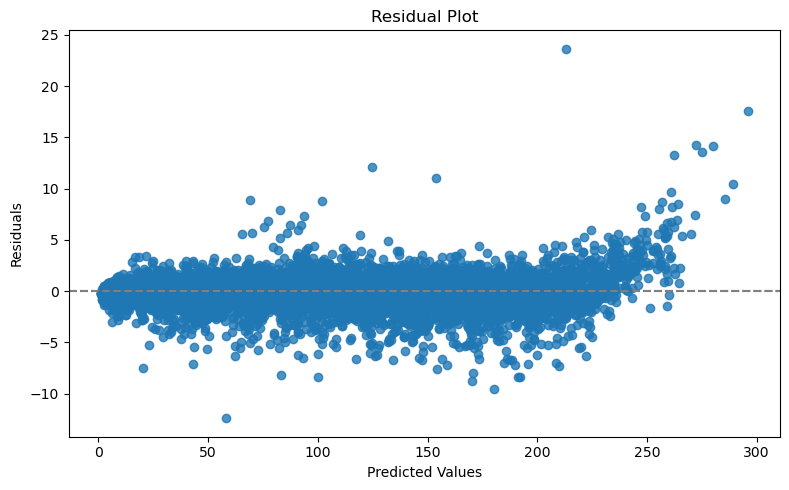

In [38]:
# make prediction
orig_pred = predictor.predict(orig)

print("Original dataset prediction RMSLE:", rmse(orig_pred, orig['Calories']))

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(orig_pred), y=np.expm1(orig['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

The model does an excellent job! (Recall: the Kaggle RMSLE was 0.05850.)

Training for longer improves score by 0.00001!  This moves us from 17/4318 to 14/4318 in the Kaggle competition.

No path specified. Models will be saved in: "AutogluonModels\ag-20250609_212233"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.58 GB / 11.33 GB (49.2%)
Disk Space Avail:   75.36 GB / 237.53 GB (31.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

(_ray_fit pid=8788) [1000]	valid_set's rmse: 0.0625831
(_ray_fit pid=11928) [1000]	valid_set's rmse: 0.0607507 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=8788) [2000]	valid_set's rmse: 0.0610258 [repeated 2x across cluster]
(_ray_fit pid=11928) [2000]	valid_set's rmse: 0.0595853 [repeated 3x across cluster]
(_ray_fit pid=8788) [3000]	valid_set's rmse: 0.0606761 [repeated 2x across cluster]
(_ray_fit pid=11928) [3000]	valid_set's rmse: 0.0593409 [repeated 3x across cluster]
(_ray_fit pid=8788) [4000]	valid_set's rmse: 0.0605654 [repeated 2x across cluster]
(_ray_fit pid=13868) [4000]	valid_set's rmse: 0.0608674 [repeated 2x across cluster]
(_ray_fit pid=11928) [4000]	valid_set's rmse: 0.059248
(_ray_fit pid=16632) [4000]	valid_set's rmse: 0.0624467
(_ray_fit pid=8788) [5000]	va

(_dystack pid=4760) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	323.26s	 = Training   runtime
(_dystack pid=4760) 	693.51s	 = Validation runtime
(_dystack pid=4760) Fitting model: LightGBM_BAG_L1 ... Training model for up to 8499.35s of the 12998.55s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=3.50%)


(_ray_fit pid=14252) [1000]	valid_set's rmse: 0.0606108
(_ray_fit pid=5388) [2000]	valid_set's rmse: 0.0594929 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0606	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	47.38s	 = Training   runtime
(_dystack pid=4760) 	38.5s	 = Validation runtime
(_dystack pid=4760) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 8438.28s of the 12937.47s of remaining time.
(_dystack pid=4760) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=4760)   warnings.warn(
(_dystack pid=4760) 	-0.0635	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	101.27s	 = Training   runtime
(_dystack pid=4760) 	16.92s	 = Validation runtime
(_dystack pid=4760) Fitting model: CatBoost_BAG_L1 ... Training model for up to 8319.24s of the 12818.43s of remaining time.
(_dystack pid=4760

(_ray_fit pid=15628) [1000]	valid_set's rmse: 0.0603741


(_dystack pid=4760) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	36.42s	 = Training   runtime
(_dystack pid=4760) 	28.25s	 = Validation runtime
(_dystack pid=4760) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 7039.38s of the 11538.57s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=10.11%)
(_ray_fit pid=16460) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\autogluon\common\utils\try_import.py:69: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_ray_fit pid=16460)   from pkg_resources import parse_version  # pylint: disable=import-outside-toplevel
(_dystack pid=4760) 	-0.06	 = Validation score   (-root_mean_s

(_ray_fit pid=9032) [1000]	valid_set's rmse: 0.0596325
(_ray_fit pid=9032) [2000]	valid_set's rmse: 0.0592112 [repeated 5x across cluster]
(_ray_fit pid=9032) [3000]	valid_set's rmse: 0.059135 [repeated 5x across cluster]
(_ray_fit pid=5060) [4000]	valid_set's rmse: 0.0606035 [repeated 5x across cluster]
(_ray_fit pid=7288) [5000]	valid_set's rmse: 0.0591161 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0603	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	143.26s	 = Training   runtime
(_dystack pid=4760) 	454.81s	 = Validation runtime
(_dystack pid=4760) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 5124.06s of the 9623.25s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=5.71%)
(_ray_fit pid=17064) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\autogluon\common\utils\try_import.py:131: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_ray_fit pid=17064)   from pkg_resources import parse_version  # pylint: disable=import-outside-toplevel
(_ray_fit pid=17064) No improvement since epoch 4: ear

(_ray_fit pid=10936) [1000]	valid_set's rmse: 0.0833397 [repeated 2x across cluster]
(_ray_fit pid=8548) [2000]	valid_set's rmse: 0.0765656 [repeated 5x across cluster]
(_ray_fit pid=10936) [3000]	valid_set's rmse: 0.0692236 [repeated 5x across cluster]
(_ray_fit pid=10936) [4000]	valid_set's rmse: 0.0662483 [repeated 5x across cluster]
(_ray_fit pid=10936) [5000]	valid_set's rmse: 0.0644492 [repeated 5x across cluster]
(_ray_fit pid=10936) [6000]	valid_set's rmse: 0.063354 [repeated 5x across cluster]
(_ray_fit pid=10936) [7000]	valid_set's rmse: 0.0627078 [repeated 5x across cluster]
(_ray_fit pid=10936) [8000]	valid_set's rmse: 0.0621875 [repeated 5x across cluster]
(_ray_fit pid=10936) [9000]	valid_set's rmse: 0.061852 [repeated 5x across cluster]
(_ray_fit pid=10936) [10000]	valid_set's rmse: 0.0616338 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0611	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	285.89s	 = Training   runtime
(_dystack pid=4760) 	1053.3s	 = Validation runtime
(_dystack pid=4760) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 1734.83s of the 6234.02s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=3.37%)
(_dystack pid=4760) 	-0.0631	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	968.13s	 = Training   runtime
(_dystack pid=4760) 	4.36s	 = Validation runtime
(_dystack pid=4760) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 760.63s of the 5259.82s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=5.02%)
(_ray_fit pid=13788) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\sit

(_ray_fit pid=14204) [1000]	valid_set's rmse: 0.0606739 [repeated 5x across cluster]
(_ray_fit pid=15168) [2000]	valid_set's rmse: 0.0586596 [repeated 5x across cluster]
(_ray_fit pid=3496) [3000]	valid_set's rmse: 0.059529 [repeated 4x across cluster]
(_ray_fit pid=12988) [4000]	valid_set's rmse: 0.0608958 [repeated 2x across cluster]
(_ray_fit pid=12988) [5000]	valid_set's rmse: 0.0608831 [repeated 2x across cluster]
(_ray_fit pid=12988) [6000]	valid_set's rmse: 0.0609023 [repeated 2x across cluster]


(_dystack pid=4760) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	269.42s	 = Training   runtime
(_dystack pid=4760) 	301.51s	 = Validation runtime
(_dystack pid=4760) Fitting model: LightGBM_BAG_L2 ... Training model for up to 4142.80s of the 4142.58s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=8.11%)
(_dystack pid=4760) 	-0.0597	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	20.16s	 = Training   runtime
(_dystack pid=4760) 	2.93s	 = Validation runtime
(_dystack pid=4760) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 4115.34s of the 4115.13s of remaining time.
(_dystack pid=4760) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.valid


Train prediction: 0.05326184149654986
Test prediction: 0.05890856866854239


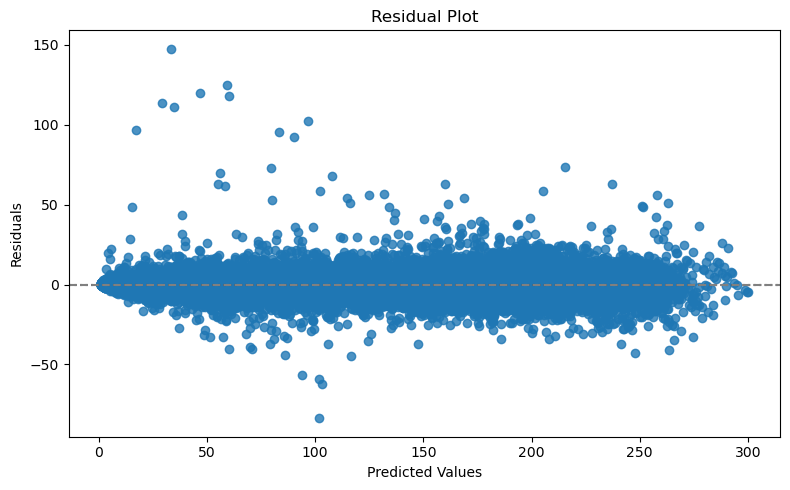

       id    Calories
0  750000   27.222017
1  750001  107.947952
2  750002   87.182053
3  750003  125.709190
4  750004   75.934334

count    250000.000000
mean         88.172859
std          62.275372
min           1.017824
25%          34.050141
50%          76.401817
75%         135.375736
max         299.757019
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.05849 private, 0.05701 public (autogluon_prediction_11.csv) (tied for 14th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=54000, # 15 hours
                                                                        num_bag_folds=5,  # 5 fold CV
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_11.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [ ]:
predictor.leaderboard().head()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059075,root_mean_squared_error,7214.105045,30590.482822,0.015257,10.400178,3,True,64
1,WeightedEnsemble_L2,-0.059187,root_mean_squared_error,1472.380559,3711.962613,0.013062,8.115282,2,True,48
2,ExtraTreesMSE_BAG_L2,-0.059404,root_mean_squared_error,6798.435167,25700.223948,30.450780,526.690415,2,True,53
3,CatBoost_r9_BAG_L2,-0.059462,root_mean_squared_error,6770.174446,25586.323037,2.190059,412.789504,2,True,62
4,LightGBMLarge_BAG_L2,-0.059492,root_mean_squared_error,6777.622296,25247.191057,9.637909,73.657524,2,True,57


In [ ]:
info['model_info']['WeightedEnsemble_L3']['features']

['ExtraTreesMSE_BAG_L2',
 'CatBoost_r167_BAG_L1',
 'CatBoost_r69_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBMLarge_BAG_L2',
 'LightGBMXT_BAG_L2',
 'NeuralNetFastAI_r156_BAG_L1',
 'CatBoost_r9_BAG_L2',
 'LightGBMLarge_BAG_L1',
 'XGBoost_r33_BAG_L1',
 'XGBoost_r194_BAG_L1',
 'RandomForestMSE_BAG_L2',
 'CatBoost_r177_BAG_L2',
 'RandomForest_r39_BAG_L1']

In [ ]:
info['model_info']['WeightedEnsemble_L3']

{'name': 'WeightedEnsemble_L3',
 'model_type': 'WeightedEnsembleModel',
 'problem_type': 'regression',
 'eval_metric': 'root_mean_squared_error',
 'stopping_metric': 'root_mean_squared_error',
 'fit_time': 10.40017819404602,
 'num_classes': None,
 'quantile_levels': None,
 'predict_time': 0.01525735855102539,
 'val_score': np.float64(-0.059075210416038915),
 'hyperparameters': {'use_orig_features': False,
  'valid_stacker': True,
  'max_base_models': 0,
  'max_base_models_per_type': 'auto',
  'save_bag_folds': True,
  'stratify': 'auto',
  'bin': 'auto',
  'n_bins': None},
 'hyperparameters_user': {'save_bag_folds': True},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': ['save_bag_folds'],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'valid_raw_types': None,
  'valid_special_types': None,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': None,
  'get_features_kwargs': None,
 

In [ ]:
predictor.feature_importance(train_data)

,importance,stddev,p_value,n,p99_high,p99_low
Duration,0.806995,0.010962,4.084816e-09,5,0.829567,0.784424
Heart_Rate,0.461166,0.013544,8.917708e-08,5,0.489054,0.433279
Age,0.113267,0.002252,1.872867e-08,5,0.117903,0.108631
Sex,0.059944,0.002045,1.622515e-07,5,0.064154,0.055733
Body_Temp,0.035696,0.001747,6.869874e-07,5,0.039294,0.032098
Weight,0.016841,0.000698,3.534277e-07,5,0.018278,0.015404
Height,0.004005,0.000377,9.331977e-06,5,0.004781,0.003228


In [ ]:
# load previous models
# predictor6 = TabularPredictor.load(r"c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250608_151409")
predictor11 = TabularPredictor.load(r"c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250609_212233")